In [27]:
using LinearAlgebra
using Distributions
using Random
using SparseArrays
using JLD2

include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("../Inversion/RWMCMC.jl")
include("Darcy-2D.jl")


aug_forward (generic function with 1 method)

# 2D Darcy Flow

Consider the Darcy flow equation on the two-dimensional spatial domain $D=[0,1]^2$, which describes the pressure field $p(x)$ in a porous medium defined by a positive permeability field $a(x,\theta)$:

$$
\begin{align*}
    -\nabla \cdot (a(x, \theta) \nabla p(x)) &= f(x), \quad &&x\in D,\\
    p(x) &= 0, \quad &&x\in \partial D.
\end{align*}
$$

For simplicity, Dirichlet boundary conditions on the pressure are applied on $\partial D$. The fluid source field $f$ is defined as

$$
\begin{align*}
    f(x_1, x_2) = \begin{cases}
               1000 & 0 \leq x_2 \leq \frac{4}{6}\\
               2000 & \frac{4}{6} < x_2 \leq \frac{5}{6}\\
               3000 & \frac{5}{6} < x_2 \leq 1\\
            \end{cases}. 
\end{align*}
$$



The equation is solved by the finite difference method similar with the [one-dimensional Darcy flow problem](../Posterior/Darcy-1D.ipynb), where computational domain is discretized by a $N \times N$ uniform grid ($N=80$ for the present study).


## Random log-Gaussian Field

Assuming that $\log a(x, \theta)$ is a centred Gaussian with covariance 
$$\mathsf{C} = (-\Delta + \tau^2 )^{-d};$$
here $-\Delta$ denotes the Laplacian on $D$ subject to homogeneous Neumann boundary conditions on the space of spatial-mean zero functions, 
$\tau > 0$ denotes the inverse length scale of the random field and $d  > 0$ determines its regularity.
The Gaussian field can be represented by the Karhunen–Loève (KL) expansion

\begin{equation}
\label{eq:KL-2d}
    \log a(x,\theta) = \sum_{l\in K} \theta_{(l)}\sqrt{\lambda_l} \psi_l(x),
\end{equation}
where $K = \mathcal{Z}^{0+}\times\mathcal{Z}^{0+} \setminus \{0,0\}$, and the eigenpairs are of the form

$$
\begin{equation*}
    \psi_l(x) = \begin{cases}
                 \sqrt{2}\cos(\pi l_1 x_1)              & l_2 = 0\\
                 \sqrt{2}\cos(\pi l_2 x_2)              & l_1 = 0\\
                 2\cos(\pi l_1 x_1)\cos(\pi l_2 x_2)    & \textrm{otherwise}\\
                 \end{cases},
                 \qquad \lambda_l = (\pi^2 |l|^2 + \tau^2)^{-d}
\end{equation*}
$$

and $\theta_{(l)} \sim \mathcal{N}(0,1)$ i.i.d. The KL expansion can be rewritten as a sum over $\mathcal{Z}^{0+}$ rather than a lattice: 

$$
\begin{equation}
\label{eq:KL-1d}
    \log a(x,\theta) = \sum_{k\in \mathcal{Z}^{0+}} \theta_{(k)}\sqrt{\lambda_k} \psi_k(x),
\end{equation}
$$

where the eigenvalues $\lambda_k$ are in descending order.
In practice, we truncate this sum to $N_\theta$ terms, based on the
largest $N_\theta$ eigenvalues, and hence $\theta\in\mathcal{R}^{N_\theta}$.
 


## Inverse Problem Setup

For the inverse problem, we recover the log-permeability field $\log a_{{ref}}(x)$ from the observation 
$y_{ref}$, which consists of pointwise measurements of the 
pressure value $p(x)$ at $49$ equidistant points in the domain. 


We generate a truth random field $\log a_{{ref}}(x)$ with $\theta \sim \mathcal{N}(0, I)$ in $\mathcal{R}^{128}$ 
(i.e. we use the first $128$ KL modes) to construct the observation $y_{obs}$.


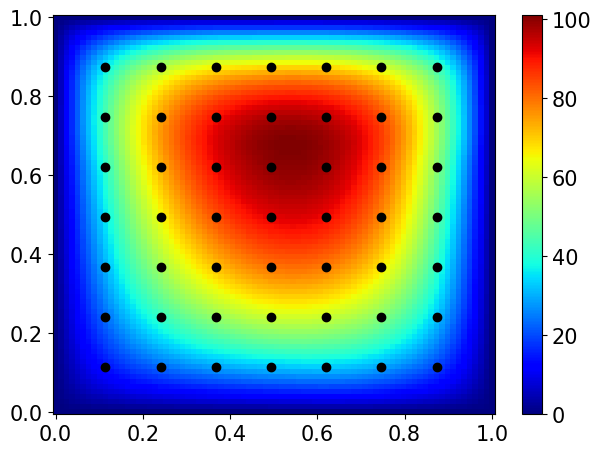

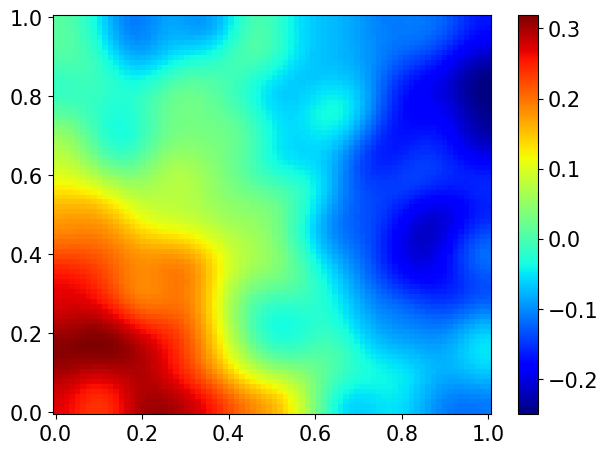

In [37]:
N, L = 80, 1.0
obs_ΔN = 10
d = 2.0
τ = 3.0
N_KL = 128
N_θ = 0
darcy = Setup_Param(N, L, N_KL, obs_ΔN, N_θ, d, τ)



κ_2d = exp.(darcy.logκ_2d)
h_2d = solve_Darcy_2D(darcy, κ_2d)
y_noiseless = compute_obs(darcy, h_2d)

figure(1)
plot_field(darcy, h_2d, true, "Darcy-2D-obs.pdf")
figure(2)
plot_field(darcy, darcy.logκ_2d, false, "Darcy-2D-logk-ref.pdf")
    

## Inverse Problem Setup : Optimization Approach

$5\%$ Gaussian random noises are added to make data $y_{obs}$:

$$
\begin{equation}
    y_{obs} = y_{ref} + \epsilon \odot  \mathcal{N}(0, I),
\end{equation}
$$

where $\epsilon = 5\% y_{ref}$, and $\odot$ denotes element-wise multiplication.




Using this data, we consider two incomplete parameterization scenarios:  
* solving for the first $32$ KL modes ($N_\theta=32$) 
* solving for the first $8$ KL modes ($N_\theta=8$).  
        
        
UKI is applied and initialized with $\theta_0 \sim \mathcal{N}(0,  I)$. 
The observation error is estimated to be $\eta \sim \mathcal{N}(0, I)$. 

### $N_\theta = 32$ Case
For the $N_\theta = 32$ case, the convergence of the log-permeability fields $\log a(x, m_n)$ and the optimization errors at each iteration for different noise levels are depicted; 
Without explicit regularization ($\alpha=1.0$), UKI suffers from overfitting for noisy scenarios: the optimization errors keep decreasing, but the parameter errors show the ``U-shape'' characteristic of overfitting. Adding regularization ($\alpha=0.5$) relieves the overfitting.

The estimated log-permeability fields $\log a(x,m_n)$ at the 20th iteration and the truth random field are depicted.  The estimated log-permeability field obtained by regularized UKI captures main features of the truth random field.



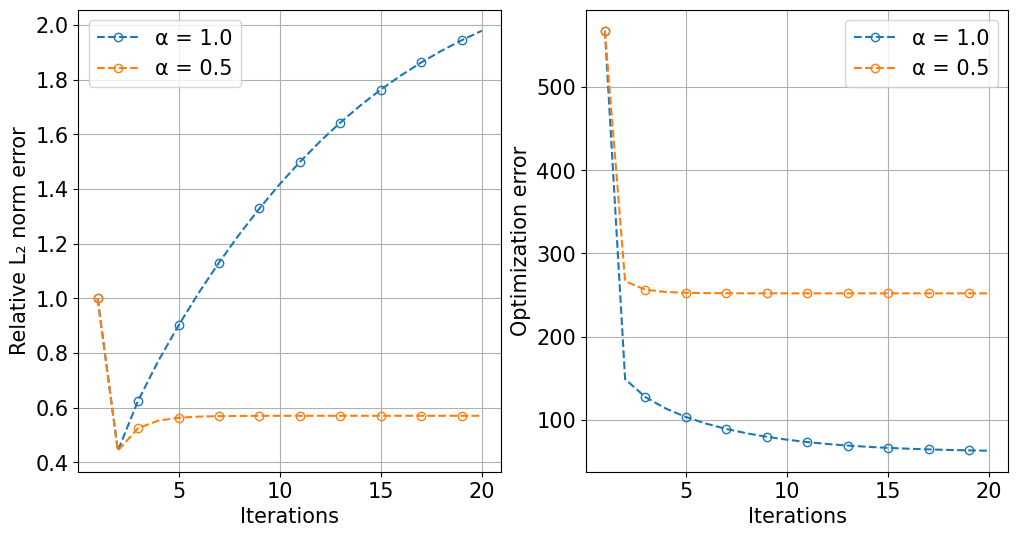

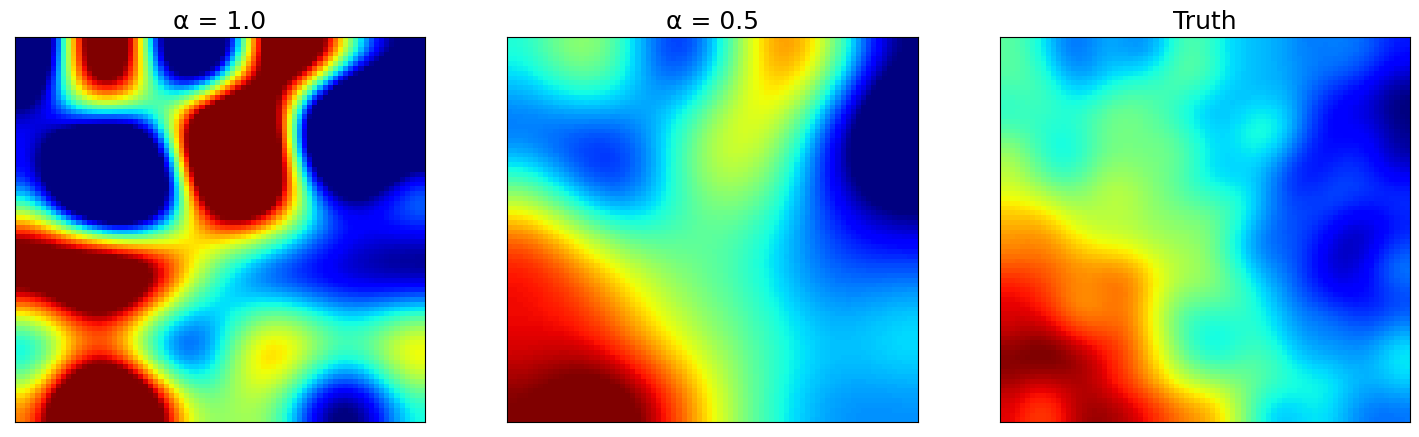

┌ Info: Start UKI on the regularized stochastic dynamical system for optimization 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:483
┌ Info: Start UKI on the regularized stochastic dynamical system for optimization 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:483


In [38]:
# N_θ = 32 case with 5% Gaussian error
N_θ = darcy.N_θ = 32
noise_level = 0.05

# observation
y = copy(y_noiseless)
Random.seed!(123);
for i = 1:length(y)
    noise = rand(Normal(0, noise_level*y[i]))
    y[i] += noise
end
Σ_η = Array(Diagonal(fill(1.0, length(y))))

# initial mean and covariance
θ0_mean = zeros(Float64, N_θ)  # mean 
θθ0_cov = Array(Diagonal(fill(1.0, N_θ)))

update_freq = 0
N_iter = 20



# visulize the error
fig, ax = PyPlot.subplots(ncols = 2, sharex=true, sharey=false, figsize=(12,6))


# visulize the log permeability field
fig_logk, ax_logk = PyPlot.subplots(ncols = 3, sharex=true, sharey=true, figsize=(18,5))
for ax in ax_logk ;  ax.set_xticks([]) ; ax.set_yticks([]) ; end
color_lim = (minimum(darcy.logκ_2d), maximum(darcy.logκ_2d))
plot_field(darcy, darcy.logκ_2d, color_lim, ax_logk[3]) 
ax_logk[3].set_title("Truth")

ites = Array(1:N_iter)
α_regs = [1.0; 0.5]
γ = 2.0
for test_id = 1:2
    α_reg = α_regs[test_id]
    
    ukiobj = UKI_Run(darcy,  forward, θ0_mean, θθ0_cov, θ0_mean, θθ0_cov, y, Σ_η, γ,  α_reg, update_freq, N_iter)

    errors = zeros(Float64, (2, N_iter))
    for i = 1:N_iter
        errors[1, i] = norm(darcy.logκ_2d - compute_logκ_2d(darcy, ukiobj.θ_mean[i]))/norm(darcy.logκ_2d)
        errors[2, i] = 0.5*(ukiobj.y_pred[i] - ukiobj.y)'*(ukiobj.Σ_η\(ukiobj.y_pred[i] - ukiobj.y)) 
    end
    
    ax[1].plot(ites, errors[1, :], linestyle="--", marker="o", fillstyle="none", markevery=2, label= "α = $(α_reg)")
    ax[1].set_ylabel("Relative L₂ norm error")
    ax[1].set_xlabel("Iterations")
    ax[1].grid(true)
    ax[1].legend()
        
        
    ax[2].plot(ites, errors[2, :], linestyle="--", marker="o", fillstyle="none", markevery=2, label= "α = $(α_reg)")
    ax[2].set_xlabel("Iterations")
    ax[2].set_ylabel("Optimization error")
    ax[2].grid(true)
    ax[2].legend()
    
    plot_field(darcy, compute_logκ_2d(darcy, ukiobj.θ_mean[end]), color_lim, ax_logk[test_id]) 
    ax_logk[test_id].set_title("α = $(α_reg)")
end


### $N_\theta = 8$ Case

For $N_\theta = 8$ case, the convergence of the log-permeability fields $\log a(x, m_n)$ and the optimization errors at each iteration for different noise levels are depicted. 
Even without explicit regularization~($\alpha=1.0$), UKI does not suffer from overfitting. 
The estimated log-permeability fields $\log a(x,m_n)$ at the 20th iteration for different noise levels, obtained by the UKI and the truth random field, are depicted. 
Comparing with the $N_\theta = 32$ case, UKI with $N_{\theta} = 8$ performs better for the $5\%$ noise scenario. This indicates the possibility of regularizing the inverse problem by reducing the parameter dimensionality.



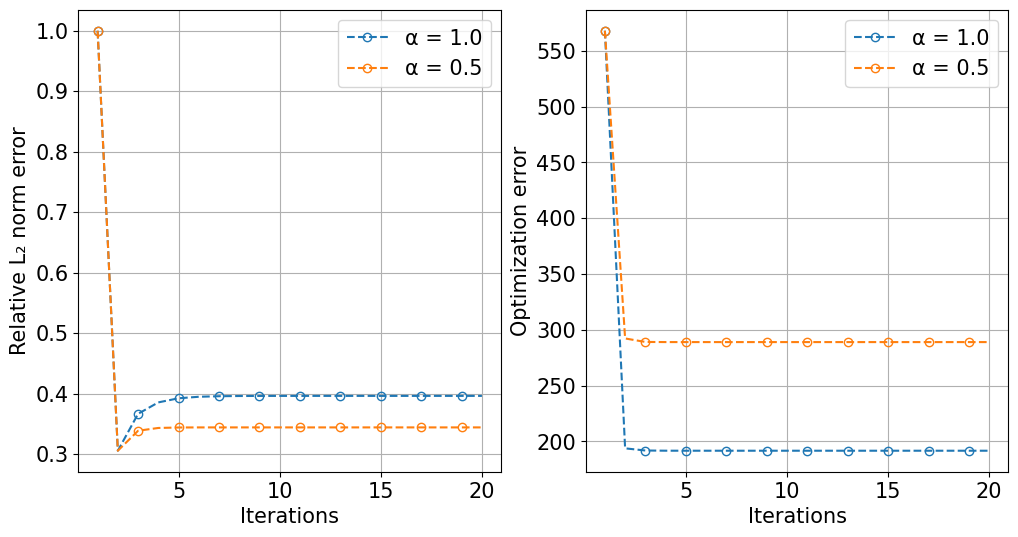

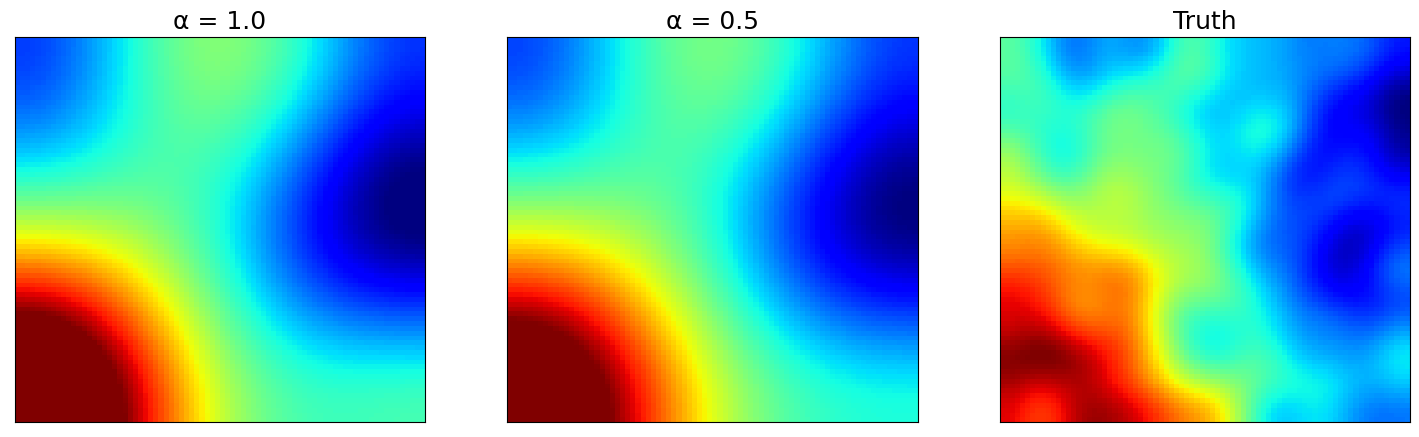

┌ Info: Start UKI on the regularized stochastic dynamical system for optimization 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:483
┌ Info: Start UKI on the regularized stochastic dynamical system for optimization 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:483


In [30]:
# N_θ = 8 case with 5% Gaussian error
N_θ = darcy.N_θ = 8
noise_level = 0.05

# observation
y = copy(y_noiseless)
Random.seed!(123);
for i = 1:length(y)
    noise = rand(Normal(0, noise_level*y[i]))
    y[i] += noise
end
Σ_η = Array(Diagonal(fill(1.0, length(y))))

# initial mean and covariance
θ0_mean = zeros(Float64, N_θ)  # mean 
θθ0_cov = Array(Diagonal(fill(1.0, N_θ)))

update_freq = 0
N_iter = 20


# visulize the error
fig, ax = PyPlot.subplots(ncols = 2, sharex=true, sharey=false, figsize=(12,6))


# visulize the log permeability field
fig_logk, ax_logk = PyPlot.subplots(ncols = 3, sharex=true, sharey=true, figsize=(18,5))
for ax in ax_logk ;  ax.set_xticks([]) ; ax.set_yticks([]) ; end
color_lim = (minimum(darcy.logκ_2d), maximum(darcy.logκ_2d))
plot_field(darcy, darcy.logκ_2d, color_lim, ax_logk[3]) 
ax_logk[3].set_title("Truth")


ites = Array(1:N_iter)
α_regs = [1.0; 0.5]
γ = 2.0
for test_id = 1:2
    α_reg = α_regs[test_id]
    
    ukiobj = UKI_Run(darcy,  forward, θ0_mean, θθ0_cov, θ0_mean, θθ0_cov, y, Σ_η, γ, α_reg, update_freq, N_iter)

    errors = zeros(Float64, (2, N_iter))
    for i = 1:N_iter
        errors[1, i] = norm(darcy.logκ_2d - compute_logκ_2d(darcy, ukiobj.θ_mean[i]))/norm(darcy.logκ_2d)
        errors[2, i] = 0.5*(ukiobj.y_pred[i] - ukiobj.y)'*(ukiobj.Σ_η\(ukiobj.y_pred[i] - ukiobj.y)) 
    end
    
    ax[1].plot(ites, errors[1, :], linestyle="--", marker="o", fillstyle="none", markevery=2, label= "α = $(α_reg)")
    ax[1].set_ylabel("Relative L₂ norm error")
    ax[1].set_xlabel("Iterations")
    ax[1].grid(true)
    ax[1].legend()
        
        
    ax[2].plot(ites, errors[2, :], linestyle="--", marker="o", fillstyle="none", markevery=2, label= "α = $(α_reg)")
    ax[2].set_xlabel("Iterations")
    ax[2].set_ylabel("Optimization error")
    ax[2].grid(true)
    ax[2].legend()
    
    plot_field(darcy, compute_logκ_2d(darcy, ukiobj.θ_mean[end]), color_lim, ax_logk[test_id]) 
    ax_logk[test_id].set_title("α = $(α_reg)")
end

## Inverse Problem Setup : Probabilistic Approachn

$$
\begin{equation}
    y_{obs} = y_{ref} + \eta
\end{equation}
$$
where observation error is assumed be $\eta \sim \mathcal{N}(0, I)$. 

Using this data, we estimate the posterior distribution of all $N_\theta=128$ modes, 
with prior $\mathcal{N}(0, I)$.
The reference posterior distribution is estimated by the preconditioned
Crank–Nicolson MCMC algorithm with $2 \times 10^6$ samples (with a $5 \times 10^5$ sample burn-in period)
with the step size 0.04. 

Different Kalman inversions equipped with the mean-field dynamical system are applied and initialized with $\theta_0 \sim \mathcal{N}(0,  I)$. 






In [31]:
function construct_cov(x::Array{FT,2}) where {FT<:AbstractFloat}
    x_mean = dropdims(mean(x, dims=1), dims=1)
    N_ens, N_x = size(x)
    x_cov = zeros(FT, N_x, N_x)
    for i = 1: N_ens
        x_cov .+= (x[i,:] - x_mean)*(x[i,:] - x_mean)'
    end
    return x_cov/(N_ens - 1)
end

function construct_mean(x::Array{FT,2}) where {FT<:AbstractFloat}    
    x_mean = dropdims(mean(x, dims=1), dims=1)
    return x_mean
end

construct_mean (generic function with 3 methods)

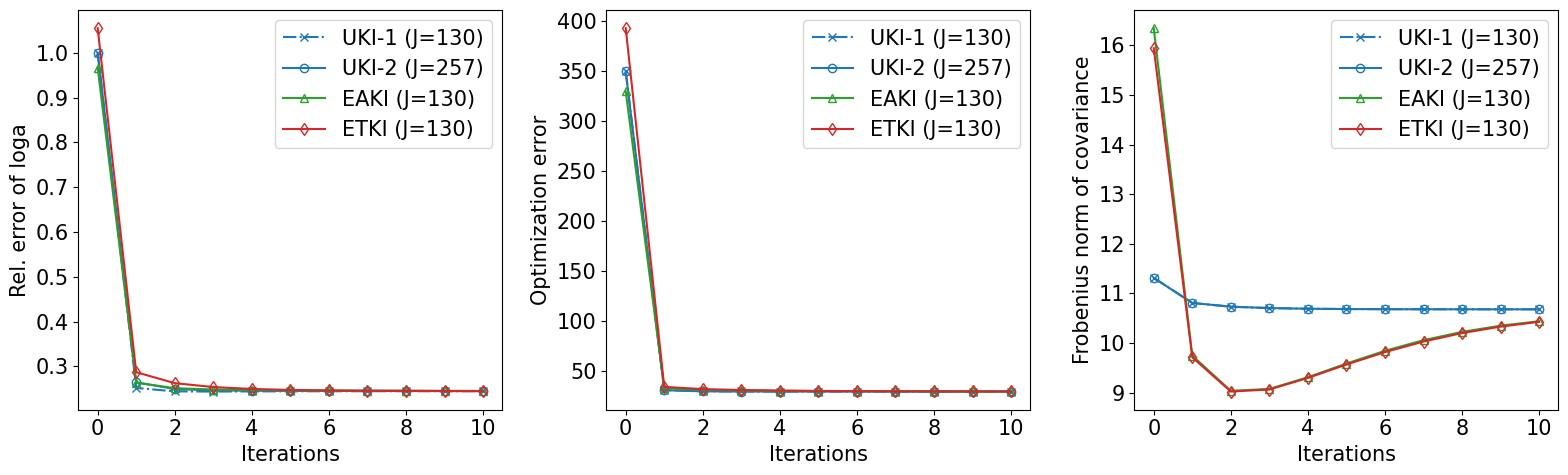

┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:469
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:469
┌ Info: ("Start ", "EAKI", " on the mean-field stochastic dynamical system for Bayesian inference ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:82
┌ Info: ("Start ", "ETKI", " on the mean-field stochastic dynamical system for Bayesian inference ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:82


In [32]:
# Noisy observation data
N_θ = darcy.N_θ = N_KL
N_y = length(y_noiseless)
# observation
y = copy(y_noiseless)
rng = MersenneTwister(123)

for i = 1:length(y)
    noise = rand(rng, Normal(0, 1.0))
    y[i] += noise
end
Σ_η = Array(Diagonal(fill(1.0, length(y))))

# initial mean and covariance
θ0_mean = zeros(Float64, N_θ)  # mean 
θθ0_cov = Array(Diagonal(fill(1.0, N_θ)))
θθ0_cov_sqrt = Array(Diagonal(fill(1.0, N_θ)))
aug_y     = [y; zeros(Float64, N_θ)] 
aug_Σ_η   = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) θθ0_cov]  
darcy.N_y = (N_y + N_θ)


# UKI
update_freq = 1
N_iter = 10
α_reg  = 1.0
γ = 1.0
uki_obj      = UKI_Run(darcy,  aug_forward, θ0_mean, θθ0_cov, θ0_mean, θθ0_cov, aug_y, aug_Σ_η, γ, α_reg, update_freq, N_iter+1; unscented_transform = "modified-n+2" );
uki_2np1_obj = UKI_Run(darcy,  aug_forward, θ0_mean, θθ0_cov, θ0_mean, θθ0_cov, aug_y, aug_Σ_η, γ, α_reg, update_freq, N_iter+1; unscented_transform = "modified-2n+1");

N_ens = 128 + 2
eaki_obj = EKI_Run(darcy,  aug_forward, "EAKI", θ0_mean, θθ0_cov_sqrt, θ0_mean, θθ0_cov_sqrt, N_ens, aug_y, aug_Σ_η, γ, α_reg, update_freq, N_iter+1);
etki_obj = EKI_Run(darcy,  aug_forward, "ETKI", θ0_mean, θθ0_cov_sqrt, θ0_mean, θθ0_cov_sqrt, N_ens, aug_y, aug_Σ_η, γ, α_reg, update_freq, N_iter+1);


##################################################

fig, (ax1, ax2, ax3) = PyPlot.subplots(ncols=3, figsize=(16,5))
ites = Array(LinRange(0, N_iter, N_iter+1))
errors = zeros(Float64, (3, N_iter+1, 4))
# UKI-1
for i = 1:N_iter+1
    errors[1, i, 1] = norm(darcy.logκ_2d - compute_logκ_2d(darcy, uki_obj.θ_mean[i]))/norm(darcy.logκ_2d)
    errors[2, i, 1] = 0.5*(uki_obj.y_pred[i] - uki_obj.y)'*(uki_obj.Σ_η\(uki_obj.y_pred[i] - uki_obj.y))
    errors[3, i, 1] = norm(uki_obj.θθ_cov[i])
end

# EAKI
for i = 1:N_iter+1
    errors[1, i, 2] = norm(darcy.logκ_2d - compute_logκ_2d(darcy, construct_mean(eaki_obj.θ[i])))/norm(darcy.logκ_2d)
    errors[2, i, 2] = 0.5*(eaki_obj.y_pred[i] - eaki_obj.y)'*(eaki_obj.Σ_η\(eaki_obj.y_pred[i] - eaki_obj.y))
    errors[3, i, 2] = norm(construct_cov(eaki_obj.θ[i])) 
end

# ETKI
for i = 1:N_iter+1
    errors[1, i, 3] = norm(darcy.logκ_2d - compute_logκ_2d(darcy, construct_mean(etki_obj.θ[i])))/norm(darcy.logκ_2d)
    errors[2, i, 3] = 0.5*(etki_obj.y_pred[i] - etki_obj.y)'*(etki_obj.Σ_η\(etki_obj.y_pred[i] - etki_obj.y))
    errors[3, i, 3] = norm(construct_cov(etki_obj.θ[i]))
end

# UKI-2
for i = 1:N_iter+1
    errors[1, i, 4] = norm(darcy.logκ_2d - compute_logκ_2d(darcy, uki_2np1_obj.θ_mean[i]))/norm(darcy.logκ_2d)
    errors[2, i, 4] = 0.5*(uki_2np1_obj.y_pred[i] - uki_2np1_obj.y)'*(uki_2np1_obj.Σ_η\(uki_2np1_obj.y_pred[i] - uki_2np1_obj.y))
    errors[3, i, 4] = norm(uki_2np1_obj.θθ_cov[i])
end

ax1.plot(ites, errors[1, :, 1], "-.x", color = "C0", fillstyle="none", markevery=1, label= "UKI-1 (J=$(N_θ+2))")
ax1.plot(ites, errors[1, :, 4], "-o",  color = "C0", fillstyle="none", markevery=1, label= "UKI-2 (J=$(2N_θ+1))")
ax1.plot(ites, errors[1, :, 2], "-^",  color = "C2", fillstyle="none", markevery=1, label= "EAKI (J=$N_ens)")
ax1.plot(ites, errors[1, :, 3], "-d",  color = "C3", fillstyle="none", markevery=1, label= "ETKI (J=$N_ens)")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Rel. error of loga")
ax1.legend()

ax2.plot(ites, errors[2, :, 1], "-.x",  color = "C0", fillstyle="none", markevery=1, label= "UKI-1 (J=$(N_θ+2))")
ax2.plot(ites, errors[2, :, 4], "-o",   color = "C0", fillstyle="none", markevery=1, label= "UKI-2 (J=$(2N_θ+1))")
ax2.plot(ites, errors[2, :, 2], "-^",   color = "C2", fillstyle="none", markevery=1, label= "EAKI (J=$N_ens)")
ax2.plot(ites, errors[2, :, 3], "-d",   color = "C3", fillstyle="none", markevery=1, label= "ETKI (J=$N_ens)")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Optimization error")
ax2.legend()

ax3.plot(ites, errors[3, :, 1], "-.x",  color = "C0", fillstyle="none", markevery=1, label= "UKI-1 (J=$(N_θ+2))")
ax3.plot(ites, errors[3, :, 4], "-o",   color = "C0", fillstyle="none", markevery=1, label= "UKI-2 (J=$(2N_θ+1))")
ax3.plot(ites, errors[3, :, 2], "-^",   color = "C2", fillstyle="none", markevery=1, label= "EAKI (J=$N_ens)")
ax3.plot(ites, errors[3, :, 3], "-d",   color = "C3", fillstyle="none", markevery=1, label= "ETKI (J=$N_ens)")
ax3.set_xlabel("Iterations")
ax3.set_ylabel("Frobenius norm of covariance")
ax3.legend()
fig.tight_layout()


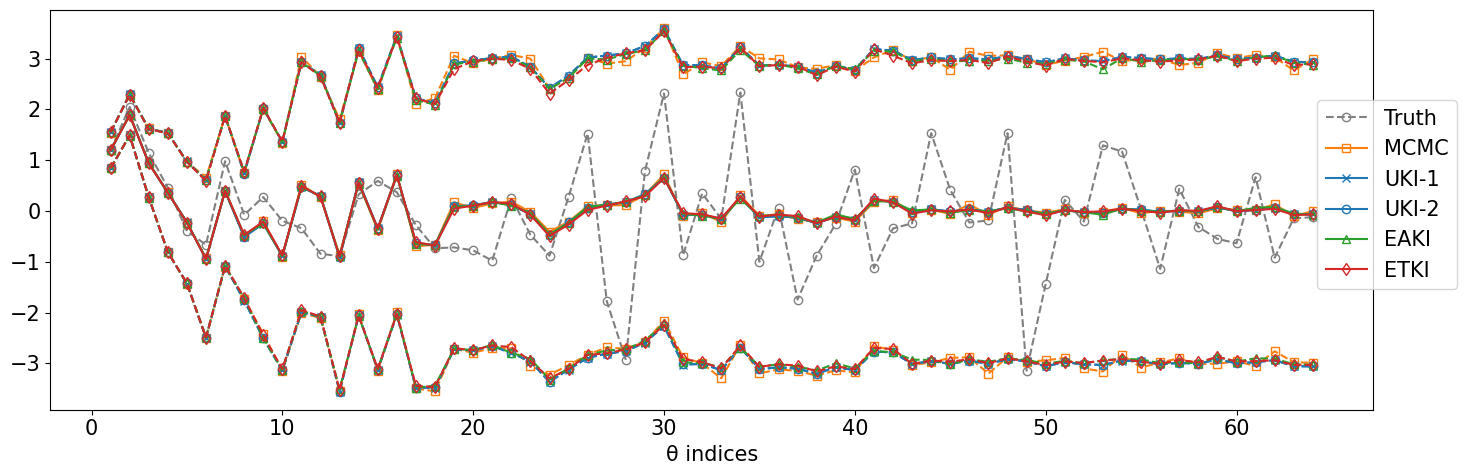

In [33]:
uki_θ_mean = uki_obj.θ_mean[end]
uki_θθ_cov = uki_obj.θθ_cov[end]
uki_θθ_std = sqrt.(diag(uki_obj.θθ_cov[end]))

uki_2np1_θ_mean = uki_2np1_obj.θ_mean[end]
uki_2np1_θθ_cov = uki_2np1_obj.θθ_cov[end]
uki_2np1_θθ_std = sqrt.(diag(uki_2np1_obj.θθ_cov[end]))

eaki_θ_mean = construct_mean(eaki_obj.θ[end])
eaki_θθ_cov = construct_cov(eaki_obj.θ[end])
eaki_θθ_std = sqrt.(diag(eaki_θθ_cov))
etki_θ_mean = construct_mean(etki_obj.θ[end])
etki_θθ_cov = construct_cov(etki_obj.θ[end])
etki_θθ_std = sqrt.(diag(etki_θθ_cov))




# compute posterior distribution by MCMC
# (uninformative) prior mean and covariance
μ0 = θ0_mean # θ_ref #
Σ0 = θθ0_cov
log_likelihood_func(θ) = log_likelihood(darcy, θ, forward, y,  Σ_η)
N_iter_MCMC , n_burn_in= 2*10^6, 5*10^5


RUN_PCN = false
if RUN_PCN

    us = PCN_Run(log_likelihood_func, μ0, Σ0, 0.04, N_iter_MCMC);

    uki_θ_mean  = ukiobj.θ_mean[end]
    uki_θθ_cov = ukiobj.θθ_cov[end]
    uki_θθ_std = sqrt.(diag(ukiobj.θθ_cov[end]))

    mcmc_θ_mean = mean(us[n_burn_in:N_iter_MCMC, :], dims=1)[:]
    mcmc_θθ_std = std(us[n_burn_in:N_iter_MCMC, :], dims=1)[:]

    save("Darcy-2D.jld2", "mean", mcmc_θ_mean, "std",  mcmc_θθ_std)

else
    
    dic = load("Darcy-2D.jld2")
    mcmc_θ_mean = dic["mean"] 
    mcmc_θθ_std = dic["std"] 
    
end





fig, ax = PyPlot.subplots(figsize=(15,5))
θ_ind = Array(1:64) 
θ_ref = darcy.θ_ref



ax.plot(θ_ind , θ_ref[θ_ind], "--o", color="grey", fillstyle="none", label="Truth")

ax.plot(θ_ind , mcmc_θ_mean[θ_ind],"-s", color="C1", fillstyle="none" , label="MCMC")
ax.plot(θ_ind , mcmc_θ_mean[θ_ind] + 3.0*mcmc_θθ_std[θ_ind], fillstyle="none", "--s", color ="C1")
ax.plot(θ_ind , mcmc_θ_mean[θ_ind] - 3.0*mcmc_θθ_std[θ_ind], fillstyle="none", "--s", color ="C1")



ax.plot(θ_ind , uki_θ_mean[θ_ind],"-x", color="C0", fillstyle="none",  label="UKI-1")
ax.plot(θ_ind , uki_θ_mean[θ_ind] + 3.0*uki_θθ_std[θ_ind], fillstyle="none", "--x", color="C0")
ax.plot(θ_ind , uki_θ_mean[θ_ind] - 3.0*uki_θθ_std[θ_ind], fillstyle="none", "--x", color="C0")

ax.plot(θ_ind , uki_2np1_θ_mean[θ_ind],"-o", color="C0", fillstyle="none",  label="UKI-2")
ax.plot(θ_ind , uki_2np1_θ_mean[θ_ind] + 3.0*uki_2np1_θθ_std[θ_ind], fillstyle="none", "--o", color="C0")
ax.plot(θ_ind , uki_2np1_θ_mean[θ_ind] - 3.0*uki_2np1_θθ_std[θ_ind], fillstyle="none", "--o", color="C0")



ax.plot(θ_ind , eaki_θ_mean[θ_ind],"-^", color="C2", fillstyle="none",  label="EAKI")
ax.plot(θ_ind , eaki_θ_mean[θ_ind] + 3.0*eaki_θθ_std[θ_ind], fillstyle="none", "--^", color="C2")
ax.plot(θ_ind , eaki_θ_mean[θ_ind] - 3.0*eaki_θθ_std[θ_ind], fillstyle="none", "--^", color="C2")


ax.plot(θ_ind , etki_θ_mean[θ_ind],"-d", color="C3", fillstyle="none",  label="ETKI")
ax.plot(θ_ind , etki_θ_mean[θ_ind] + 3.0*etki_θθ_std[θ_ind], fillstyle="none",  "--d",color="C3")
ax.plot(θ_ind , etki_θ_mean[θ_ind] - 3.0*etki_θθ_std[θ_ind], fillstyle="none",  "--d", color="C3")



ax.legend(bbox_to_anchor=(0.95, 0.8))
# plot MCMC results 
ax.set_xlabel("θ indices")
fig.tight_layout()

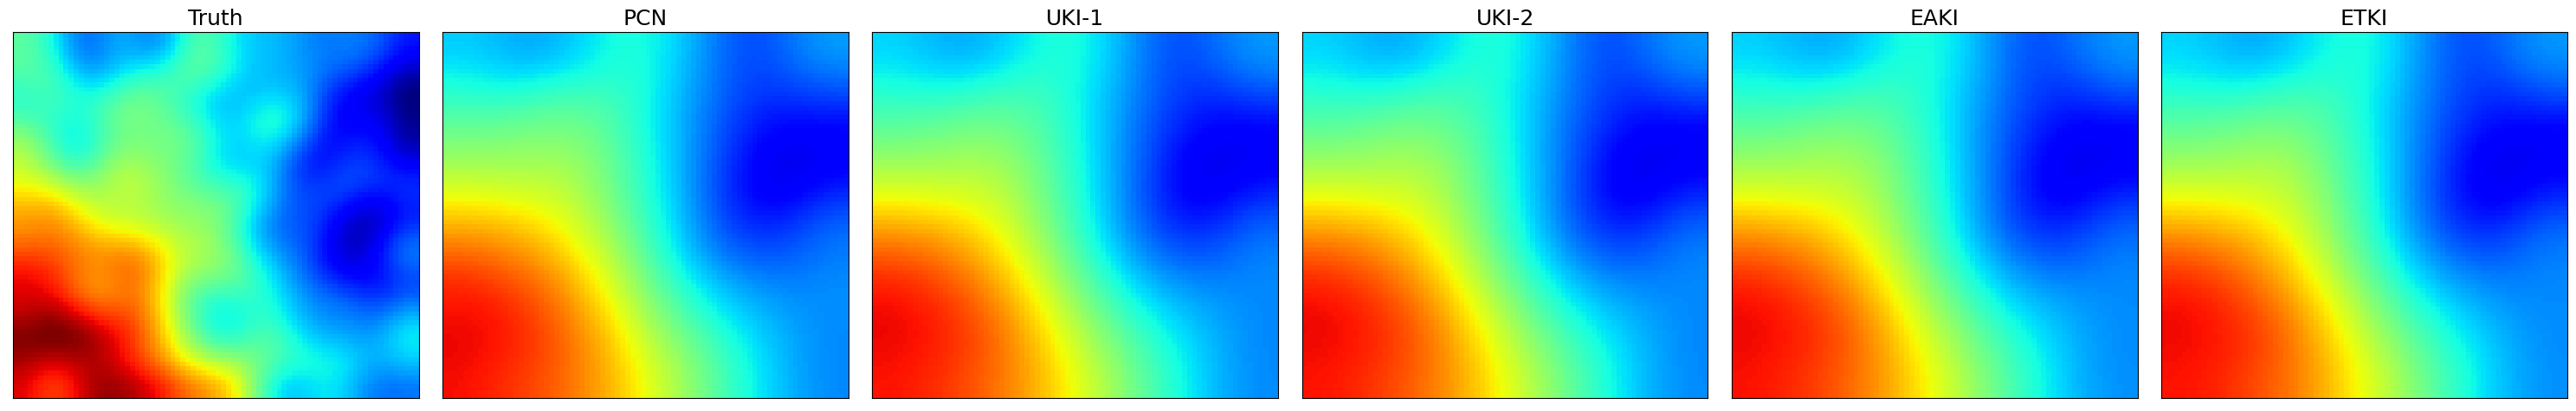

In [34]:
# visulize the log permeability field
fig_logk, ax_logk = PyPlot.subplots(ncols = 6, sharex=true, sharey=true, figsize=(30,5))
for ax in ax_logk ;  ax.set_xticks([]) ; ax.set_yticks([]) ; end
color_lim = (minimum(darcy.logκ_2d), maximum(darcy.logκ_2d))

plot_field(darcy, darcy.logκ_2d, color_lim, ax_logk[1]) 
ax_logk[1].set_title("Truth")
plot_field(darcy, compute_logκ_2d(darcy, mcmc_θ_mean),       color_lim, ax_logk[2]) 
ax_logk[2].set_title("PCN")
plot_field(darcy, compute_logκ_2d(darcy, uki_θ_mean),        color_lim, ax_logk[3]) 
ax_logk[3].set_title("UKI-1")
plot_field(darcy, compute_logκ_2d(darcy, uki_2np1_θ_mean),   color_lim, ax_logk[4])
ax_logk[4].set_title("UKI-2")
plot_field(darcy, compute_logκ_2d(darcy, eaki_θ_mean ),      color_lim, ax_logk[5]) 
ax_logk[5].set_title("EAKI")
plot_field(darcy, compute_logκ_2d(darcy, etki_θ_mean ),      color_lim, ax_logk[6]) 
ax_logk[6].set_title("ETKI")


fig_logk.tight_layout()